In [ ]:
# --------------------- Import các thư viện cần thiết ---------------------

from tqdm import tqdm  #Hiển thị thanh tiến trình.
import time            #Đo thời gian thực thi.
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, ElectraTokenizer, ElectraModel #Thư viện cung cấp mô hình pre-trained như ELECTRA.
from torch.optim import AdamW
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#----------------------Xử lý data-Chia tập dữ liệu huấn luyện---------------------------------

# Đọc dataset đã qua tiền xử lý dữ liệu
news_df = pd.read_csv('/kaggle/input/dataset-fakenews-v6/news_process_v6.csv')
fakenews_df= pd.read_csv('/kaggle/input/dataset-fakenews-v6/fakenews_process_v6.csv')

# Gộp dữ liệu Title và Content lại thành dữ liệu để huấn luyện
news_df['Data_input'] = news_df['Title'].fillna('') + " " + news_df['Content'].fillna('')
fakenews_df['Data_input'] = fakenews_df['Title'].fillna('') + " " + fakenews_df['Content'].fillna('')

# Đảm bảo title và content là chuỗi
news_df['Data_input'] = [str(text) for text in news_df['Data_input']] 
fakenews_df['Data_input'] = [str(text) for text in fakenews_df['Data_input']] 
def change_label_to_int(text):
    result = 0 if text.strip() == "Real" else 1
    return result
    
# Đảm bảo nhãn là kiểu số nguyên
news_df['Label'] = news_df['Label'].apply(change_label_to_int).astype(int)
fakenews_df['Label'] = fakenews_df['Label'].apply(change_label_to_int).astype(int)

# Xóa cột không cần thiết
news_df.drop(['Title','Content','Source', 'DataTime'], axis=1, inplace=True)
fakenews_df.drop(['Title','Content','Source', 'DataTime'], axis=1, inplace=True)

print("\nSố lượng tin thật ",len(news_df))
print("Số lượng tin giả: ",len(fakenews_df))

# Hàm chia các tập data
def split_data(df, split_size):
    train_size = int(split_size[0] * len(df))
    val_size = int(split_size[1] * len(df))

    df_train = df[:train_size]
    df_val = df[train_size:train_size+val_size]
    df_test = df[train_size + val_size:]
    return df_train, df_val, df_test
# tiến hành chia data     
split = [0.6, 0.2, 0.2]
news_df_train, news_df_val, news_df_test = split_data(news_df, split)
fakenews_df_train, fakenews_df_val, fakenews_df_test = split_data(fakenews_df, split)

# gộp data tin giả và tin thật
train_data = pd.concat([fakenews_df_train, news_df_train], ignore_index=True)
val_data = pd.concat([fakenews_df_val, news_df_val], ignore_index=True)
test_data = pd.concat([fakenews_df_test, news_df_test], ignore_index=True)

train_data = train_data.sample(frac=1).reset_index(drop=True)
val_data = val_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

# # Gộp dữ liệu tin thật và tin giả
# all_data = pd.concat([news_df, fakenews_df]).reset_index(drop=True)
# all_data = all_data[all_data['Data_input'].str.strip() != ""]
# # Chia thành tập train (70%) và tập tạm (30%)
# train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42, stratify=all_data['Label'])

# # Chia tập tạm thành validation (20%) và test (10%)
# val_data, test_data = train_test_split(temp_data, test_size=0.3333, random_state=42, stratify=temp_data['Label'])

print("\nSố lượng dữ liệu trong tập train:", len(train_data))
print(train_data[0:20])
print("\nSố lượng dữ liệu trong tập validation:", len(val_data))
print(val_data[0:5])
print("\nSố lượng dữ liệu trong tập test:", len(test_data))
print(test_data[0:5])


Số lượng tin thật  16258
Số lượng tin giả:  16068

Số lượng dữ liệu trong tập train: 19394
    Label                                         Data_input
0       1  đêm thắp nến cầu_nguyện nạn_nhân đấu_tranh dân...
1       0  chú_ý putin mời tổng_thống mông cổ tham_dự hội...
2       0  trao quyết_định chủ_tịch 7 sĩ_quan quân_đội gì...
3       0   nghĩa lương tạp_vụ kỹ_sư nghĩa bộ_trưởng mong...
4       0  thủ_tướng nghiên_cứu huy_động 100 000 tỷ đồng ...
5       0  bí_thư tp hcm tập_trung giải_quyết dứt_điểm kh...
6       0  hà_nội kiểm_tra dấu_hiệu vi_phạm liên_quan dự_...
7       1  chỉ_thị thời công_an bảo_vệ đảng 2010 nhân kỷ_...
8       0  giúp nông_dân vươn làm_giàu tổng_bí_thư nguyễn...
9       1   cơ_bản phái_đoàn nông đức tiếp_tục dàn_chào s...
10      1  dân hay_là nạn dân cơ_sở cơ_quan công_an khẩu_...
11      0  tổng_bí_thư nguyễn_phú_trọng chạm trái_tim mến...
12      0  singapore đón trọng_thể thủ_tướng phạm_minh_ch...
13      1  ts quân trò ly_gián chế_độ liên_kết yêu 03 

In [3]:
# --------------------- 1. Dataset Class ---------------------

# Lớp Dataset: Fakenews_Dataset
# Quản lý và xử lý dữ liệu đầu vào trước khi đưa vào mô hình.
class Fakenews_Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512, stride=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        self.examples = self.tokenize_texts()
    
    # Kỹ thuật cửa sổ trượt chia đoạn văn bản dài
    # Chia văn bản dài thành các đoạn ngắn có độ dài tối đa max_length.
    # Áp dụng padding nếu cần thiết để đảm bảo kích thước đồng nhất.
    
    def sliding_window_tokenize(self, text, label):
        tokens = self.tokenizer(text)["input_ids"] # tokenizer toàn bộ từ trong bài báo
        token_windows, label_windows = [], []
        for i in range(0, len(tokens), self.max_length - self.stride):
            window = tokens[i:i + self.max_length]
            if len(window) < self.max_length:
                window += [self.tokenizer.pad_token_id] * (self.max_length - len(window))
            token_windows.append(window)
            label_windows.append(label)
        return token_windows, label_windows

    def tokenize_texts(self):
        all_token_windows = []
        all_labels = []
        for text, label in zip(self.texts, self.labels):
            token_windows, label_windows = self.sliding_window_tokenize(text, label)
            all_token_windows.extend(token_windows)
            all_labels.extend(label_windows)
        return list(zip(all_token_windows, all_labels))

    def __len__(self):
        return len(self.examples)

    
    # Lấy một mẫu dữ liệu với các thành phần:
    # input_ids: Mã hóa từ.
    # attention_mask: Đánh dấu các vị trí cần chú ý.
    # label: Nhãn của mẫu.
    def __getitem__(self, idx):
        input_ids, label = self.examples[idx]
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': torch.tensor(label, dtype=torch.long)}

In [4]:

# # --------------------- 2. Transformer Model -----------------------

# # Mô hình cơ bản: TransformerELECTRA
# # Sử dụng mô hình ElectraModel để trích xuất đặc trưng.
# # Kết nối với lớp phân loại (nn.Linear) để đưa ra kết quả.
# class TransformerELECTRA(nn.Module):
#     def __init__(self, model_name='google/electra-base-discriminator', num_labels=2):
#         super(TransformerELECTRA, self).__init__()
#         self.electra = ElectraModel.from_pretrained(model_name)
#         self.classifier = nn.Linear(self.electra.config.hidden_size, num_labels)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
#         sequence_output = outputs.last_hidden_state
#         cls_token_output = sequence_output[:, 0, :]
#         cls_token_output = self.dropout(cls_token_output)
#         logits = self.classifier(cls_token_output)
#         return logits


# Mô hình cải tiến: CustomELECTRAModel
# Thêm cơ chế Attention để trọng số hóa các đặc trưng quan trọng: self.attention = nn.MultiheadAttention(...)
# Lớp LayerNorm cải thiện ổn định trong huấn luyện.
class CustomELECTRAModel(nn.Module):
    def __init__(self, model_name, num_labels=2):
        super(CustomELECTRAModel, self).__init__()
        self.electra = ElectraModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(
            embed_dim=self.electra.config.hidden_size, 
            num_heads=8, 
            batch_first=True
        )
        self.fc1 = nn.Linear(self.electra.config.hidden_size, 128)
        self.fc2 = nn.Linear(128, num_labels)
        self.dropout = nn.Dropout(0.3)
        
        # Thêm lớp LayerNorm
        self.layer_norm = nn.LayerNorm(128)

    def forward(self, input_ids, attention_mask):
        # Trích xuất embeddings từ ELECTRA
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Attention pooling
        attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states, key_padding_mask=~attention_mask.bool())
        
        # Chọn CLS token làm đặc trưng đại diện
        cls_token_output = attn_output[:, 0, :]  # CLS token tương ứng với đầu tiên của sequence output

        # Fully connected layers
        pooled_output = self.dropout(cls_token_output)  # Áp dụng dropout
        fc1_output = torch.relu(self.fc1(pooled_output))
        
        # Áp dụng Layer Normalization sau FC1
        fc1_output = self.layer_norm(fc1_output)
        
        logits = self.fc2(fc1_output)
        return logits


# --------------------- 3. Trainer Class -----------------------------------------

# Tập trung vào huấn luyện và đánh giá mô hình.
class ClassifierTrainer:
    def __init__(self, model, train_dataloader, val_dataloader, device, lr=2e-5, epochs=3, accumulation_steps=4, checkpoint_dir="/kaggle/working/"):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        self.lr = lr
        self.epochs = epochs
        self.accumulation_steps = accumulation_steps
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.9)
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = torch.amp.GradScaler()  # Mixed Precision
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Lưu loss và accuracy để vẽ biểu đồ
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    # Huấn luyện một epoch
    # Chạy từng batch dữ liệu qua mô hình.
    # Tính toán và tối ưu hóa loss.
    # Sử dụng autocast và GradScaler để tăng tốc với Mixed Precision.
    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss, total_correct = 0, 0
        previous_percent = 0  # Biến lưu trữ tiến độ trước đó
    
        print(f"Epoch {epoch + 1}: Training...")
        start_time = time.time()

        for step, batch in enumerate(self.train_dataloader):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['label'].to(self.device)
    
            with torch.amp.autocast(device_type='cuda'):  # Mixed Precision
                logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = self.criterion(logits, labels) / self.accumulation_steps
    
            self.scaler.scale(loss).backward()
    
            if (step + 1) % self.accumulation_steps == 0 or (step + 1) == len(self.train_dataloader):
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
    
            total_loss += loss.item() * self.accumulation_steps
            total_correct += (logits.argmax(dim=-1) == labels).sum().item()
    
            # Tính phần trăm hoàn thành
            current_percent = int(100 * (step + 1) / len(self.train_dataloader))
            if current_percent != previous_percent:  # Chỉ in khi phần trăm thay đổi
                previous_percent = current_percent
                avg_loss = total_loss / (step + 1)
                accuracy = total_correct / ((step + 1) * self.train_dataloader.batch_size)
                print(f"Progress: {current_percent}% | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

        epoch_time = time.time() - start_time
        print(f"  Training completed in {epoch_time:.2f} seconds.")
        avg_loss = total_loss / len(self.train_dataloader)
        accuracy = total_correct / len(self.train_dataloader.dataset)
        
        # Lưu giá trị loss và accuracy cho vẽ biểu đồ
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
    
        return avg_loss, accuracy

    # Đánh giá mô hình
    # Đánh giá trên tập validation.
    # Tính loss, accuracy và lưu các giá trị để vẽ biểu đồ.
    def evaluate(self, epoch):
        """
        Đánh giá trên tập Validation.
        """
        self.model.eval()
        total_loss, total_correct = 0, 0
        all_labels = []  # Khởi tạo danh sách trống
        all_preds = []   # Khởi tạo danh sách trống
        previous_percent = 0  # Biến lưu trữ tiến độ trước đó
    
        print(f"Epoch {epoch + 1}: Evaluating (Validation)...")
        start_time = time.time()
    
        with torch.no_grad():
            for step, batch in enumerate(self.val_dataloader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)
    
                with torch.amp.autocast(device_type='cuda'):
                    logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = self.criterion(logits, labels)
    
                total_loss += loss.item()
                total_correct += (logits.argmax(dim=-1) == labels).sum().item()
    
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(logits.argmax(dim=-1).cpu().numpy())
    
                # Tính phần trăm hoàn thành
                current_percent = int(100 * (step + 1) / len(self.val_dataloader))
                if current_percent != previous_percent:  # Chỉ in khi phần trăm thay đổi
                    previous_percent = current_percent
                    avg_loss = total_loss / (step + 1)
                    accuracy = total_correct / ((step + 1) * self.val_dataloader.batch_size)
                    print(f"Progress: {current_percent}% | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
    
        epoch_time = time.time() - start_time
        print(f"  Validation completed in {epoch_time:.2f} seconds.")
        avg_loss = total_loss / len(self.val_dataloader)
        accuracy = total_correct / len(self.val_dataloader.dataset)
        
        # Lưu giá trị loss và accuracy cho vẽ biểu đồ
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
    
        return avg_loss, accuracy


    # Hàm huấn luyện
    def train(self):
        best_val_acc = 0.0
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_one_epoch(epoch)
            val_loss, val_acc = self.evaluate(epoch)

            self.scheduler.step()

            print(f"Epoch {epoch + 1}/{self.epochs}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

            # Lưu mô hình tốt nhất
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_best_checkpoint(epoch, val_acc)
                
        # Hiển thị kết quả cuối cùng
        final_train_loss = self.train_losses[-1]
        final_train_acc = self.train_accuracies[-1]
        final_val_loss = self.val_losses[-1]
        final_val_acc = self.val_accuracies[-1]
    
        print("\n===== Training Completed =====")
        print(f"Final Train Loss: {final_train_loss:.4f} | Final Train Accuracy: {final_train_acc:.4f}")
        print(f"Final Val Loss: {final_val_loss:.4f} | Final Val Accuracy: {final_val_acc:.4f}")

    # Vẽ biểu đồ Loss và Accuracy theo từng epoch.
    def plot_metrics(self):
        epochs_range = range(1, self.epochs + 1)

        # Vẽ biểu đồ loss
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, self.train_losses, label='Train Loss')
        plt.plot(epochs_range, self.val_losses, label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Vẽ biểu đồ accuracy
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs_range, self.val_accuracies, label='Val Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Lưu trạng thái mô hình có độ chính xác cao nhất trên tập validation.
    def save_best_checkpoint(self, epoch, val_acc):
        """
        Lưu checkpoint tốt nhất.
        """
        checkpoint_path = os.path.join(self.checkpoint_dir, f"best_model_epoch_{epoch + 1}_val_acc_{val_acc:.4f}.pth")
        torch.save(self.model, checkpoint_path)
        print(f"  Saved best model to {checkpoint_path}") 

In [5]:
!pip install ipywidgets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 

In [6]:
# --------------------- 4. Dataset và Dataloader ---------------------

# Tải mô hình ELECTRA-Base
model_name='google/electra-base-discriminator' 
tokenizer = ElectraTokenizer.from_pretrained(model_name)

# Lưu tokenizer
tokenizer.save_pretrained("/kaggle/working/tokenizer")

train_dataset = Fakenews_Dataset(
    texts=train_data['Data_input'].tolist(),
    labels=train_data['Label'].tolist(),
    tokenizer=tokenizer
)
print(f"\nSố lượng mẫu train: từ {len(train_data)} mẫu đã tăng lên {len(train_dataset)} mẫu")

val_dataset = Fakenews_Dataset(
    texts=val_data['Data_input'].tolist(),
    labels=val_data['Label'].tolist(),
    tokenizer=tokenizer
)
print(f"\nSố lượng mẫu val: từ {len(val_data)} mẫu đã tăng lên {len(val_dataset)} mẫu")
#DataLoader Optimization
# Tối ưu hóa DataLoader:
# Sử dụng pin_memory và num_workers để tăng tốc độ nạp dữ liệu.
# Có collate_fn để xử lý batch đầu vào cho mô hình

# Hàm collate_fn , mỗi batch sẽ có 3 trường dữ liệu
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': labels}
    
#shuffle=True: Mỗi khi một epoch mới bắt đầu, các mẫu trong tập dữ liệu huấn luyện sẽ được trộn ngẫu nhiên
# Tạo DataLoader với collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1078 > 512). Running this sequence through the model will result in indexing errors



Số lượng mẫu train: từ 19394 mẫu đã tăng lên 101486 mẫu

Số lượng mẫu val: từ 6464 mẫu đã tăng lên 33851 mẫu


In [7]:
# --------------------- 5. Huấn luyện mô hình ---------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomELECTRAModel(model_name).to(device)

trainer = ClassifierTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    lr=2e-5,
    epochs=6,
    accumulation_steps=4
)

trainer.train()  # Huấn luyện mô hình

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Training...
Progress: 1% | Loss: 0.6662 | Accuracy: 0.6412
Progress: 2% | Loss: 0.6115 | Accuracy: 0.6819
Progress: 3% | Loss: 0.5525 | Accuracy: 0.7238
Progress: 4% | Loss: 0.4988 | Accuracy: 0.7542
Progress: 5% | Loss: 0.4478 | Accuracy: 0.7835
Progress: 6% | Loss: 0.4141 | Accuracy: 0.8031
Progress: 7% | Loss: 0.3950 | Accuracy: 0.8141
Progress: 8% | Loss: 0.3713 | Accuracy: 0.8272
Progress: 9% | Loss: 0.3514 | Accuracy: 0.8378
Progress: 10% | Loss: 0.3436 | Accuracy: 0.8431
Progress: 11% | Loss: 0.3340 | Accuracy: 0.8494
Progress: 12% | Loss: 0.3218 | Accuracy: 0.8555
Progress: 13% | Loss: 0.3126 | Accuracy: 0.8607
Progress: 14% | Loss: 0.3018 | Accuracy: 0.8664
Progress: 15% | Loss: 0.2909 | Accuracy: 0.8721
Progress: 16% | Loss: 0.2822 | Accuracy: 0.8761
Progress: 17% | Loss: 0.2747 | Accuracy: 0.8799
Progress: 18% | Loss: 0.2671 | Accuracy: 0.8839
Progress: 19% | Loss: 0.2594 | Accuracy: 0.8877
Progress: 20% | Loss: 0.2536 | Accuracy: 0.8907
Progress: 21% | Loss: 0.2494

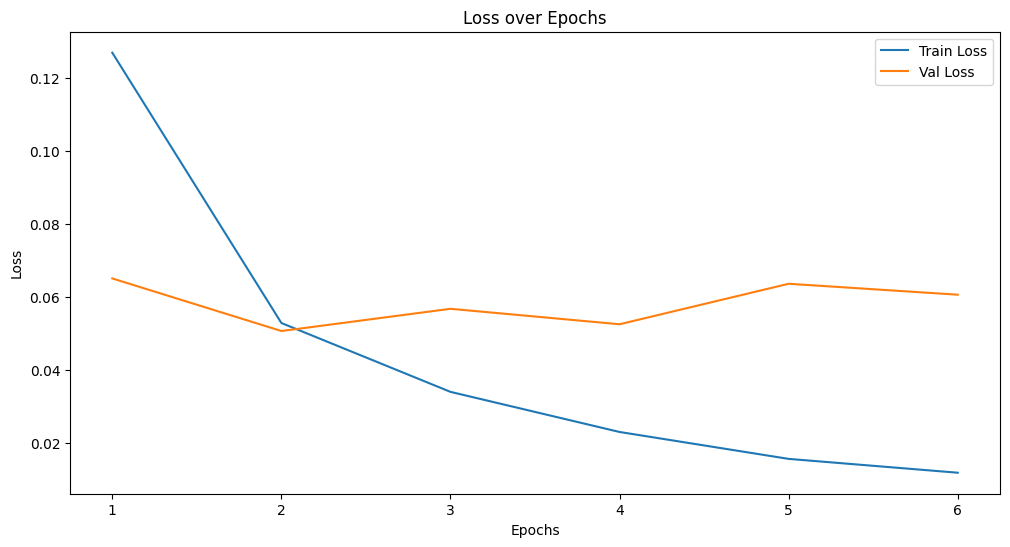

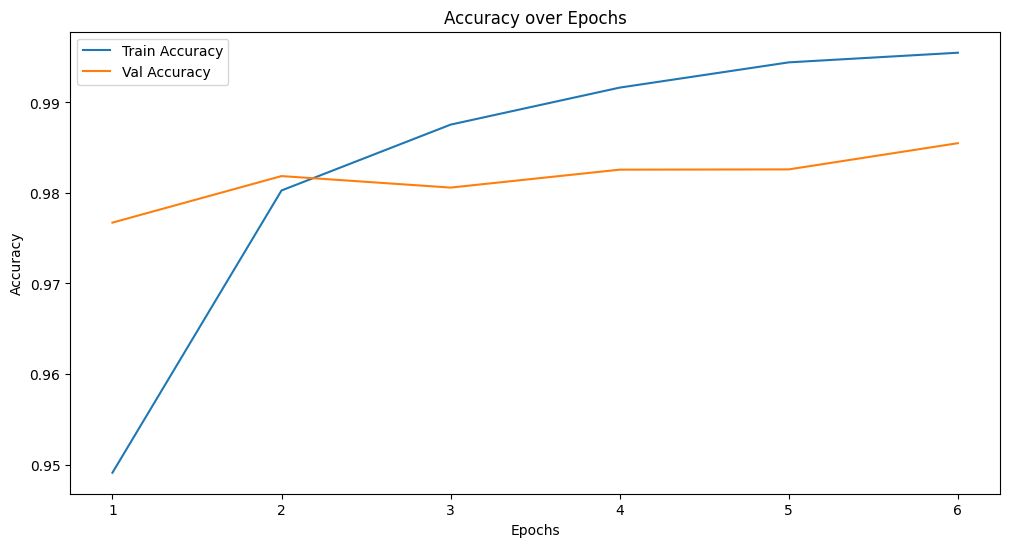

In [8]:
#------------------------ Vẽ biểu đồ kết quả------------------------------------
trainer.plot_metrics() # kết quả biểu đồ

**Test**

In [9]:
# class CustomELECTRAModel(nn.Module):
#     def __init__(self, model_name, num_labels=2):
#         super(CustomELECTRAModel, self).__init__()
#         self.electra = ElectraModel.from_pretrained(model_name)
#         self.attention = nn.MultiheadAttention(
#             embed_dim=self.electra.config.hidden_size, 
#             num_heads=8, 
#             batch_first=True
#         )
#         self.fc1 = nn.Linear(self.electra.config.hidden_size, 128)
#         self.fc2 = nn.Linear(128, num_labels)
#         self.dropout = nn.Dropout(0.3)
#         # Thêm lớp LayerNorm
#         self.layer_norm = nn.LayerNorm(128)

#     def forward(self, input_ids, attention_mask):
#         # Trích xuất embeddings từ ELECTRA
#         outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
#         # Attention pooling
#         attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states, key_padding_mask=~attention_mask.bool())
#         # Chọn CLS token làm đặc trưng đại diện
#         cls_token_output = attn_output[:, 0, :]  # CLS token tương ứng với đầu tiên của sequence output
#         # Fully connected layers
#         pooled_output = self.dropout(cls_token_output)  # Áp dụng dropout
#         fc1_output = torch.relu(self.fc1(pooled_output))
#         # Áp dụng Layer Normalization sau FC1
#         fc1_output = self.layer_norm(fc1_output)
#         logits = self.fc2(fc1_output)
#         return logits
# # Tải mô hình ELECTRA-Base
# model_name='google/electra-base-discriminator' 
# tokenizer = ElectraTokenizer.from_pretrained(model_name)

# model_path = '/kaggle/input/model-test/best_model_epoch_4_val_acc_0.9854.pth'
# # Load the trained model weights
# # model = CustomELECTRAModel(model_name=model_name)
# model = torch.load(model_path, map_location=torch.device('cuda'))
# # model.to('cuda' if torch.cuda.is_available() else 'cpu')
# model.eval()

Predicting on test data: 100%|██████████| 6468/6468 [13:22<00:00,  8.06it/s]



Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3253
           1       0.99      1.00      0.99      3215

    accuracy                           0.99      6468
   macro avg       0.99      0.99      0.99      6468
weighted avg       0.99      0.99      0.99      6468



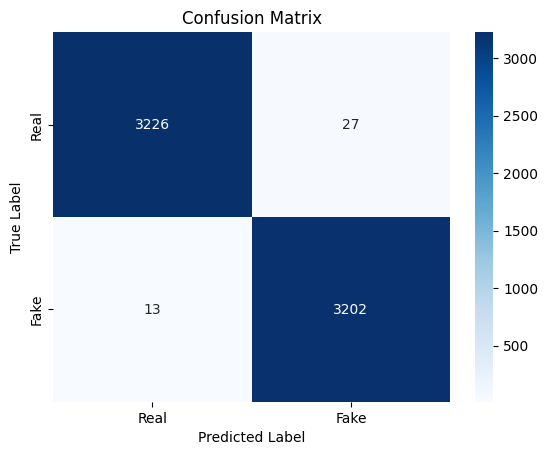

In [10]:

class SlidingWindowPredictor:
    def __init__(self, model, tokenizer, max_length=512, stride=128, device='cuda'):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        self.device = device
        
    def sliding_window_tokenize(self, text):
        tokens = self.tokenizer.encode(text, add_special_tokens=True)
        token_windows = []
        for i in range(0, len(tokens), self.max_length - self.stride):
            window = tokens[i:i + self.max_length]
            if len(window) < self.max_length:
                window += [self.tokenizer.pad_token_id] * (self.max_length - len(window))
            token_windows.append(window)
        return token_windows

    def predict_label(self, text):
        token_windows = self.sliding_window_tokenize(text)
        predictions = []
        self.model.eval()
        with torch.no_grad():
            for window in token_windows:
                inputs = {
                    'input_ids': torch.tensor([window]).to(self.device),
                    'attention_mask': torch.tensor([[1 if token != self.tokenizer.pad_token_id else 0 for token in window]]).to(self.device)
                }
                # logits = self.model(**inputs).logits
                logits=self.model.forward(inputs['input_ids'], inputs['attention_mask'])
                predictions.append(torch.argmax(logits, dim=1).item())
        
        # Majority vote
        label_count = Counter(predictions)
        if label_count[0] == label_count[1]:
            return 1
        return label_count.most_common(1)[0][0]

# Tạo đối tượng dự đoán
predictor = SlidingWindowPredictor(model, tokenizer, max_length=512, stride=128, device=device)

# Dự đoán nhãn trên tập test_data
y_true = test_data['Label'].tolist()
y_pred = []
for text in tqdm(test_data['Data_input'], desc="Predicting on test data"):
    y_pred.append(predictor.predict_label(text))

# Báo cáo kết quả
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# **Test với bài báo thực tế**

In [11]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline
# import re
# import os

# device = torch.device('cuda')
# tokenizer = AutoTokenizer.from_pretrained("NlpHUST/vi-word-segmentation")
# model_seg = AutoModelForTokenClassification.from_pretrained("NlpHUST/vi-word-segmentation").to(device)

# nlp = pipeline("token-classification", model=model_seg, tokenizer=tokenizer)

In [12]:
# def word_weg(text, nlp):
#   ner_results = nlp(text)
#   example_tok = ""
#   for e in ner_results:
#       if "##" in e["word"]:
#           example_tok = example_tok + e["word"].replace("##","")
#       elif e["entity"] =="I":
#           example_tok = example_tok + "_" + e["word"]
#       elif ("." in e["word"]) or ("/" in e["word"]) or ("%" in e["word"]) or ("-" in e["word"]):
#         example_tok = example_tok + "" + e["word"]
#       else:
#         example_tok = example_tok + " " + e["word"]
#   return example_tok
    
# # Hàm tiền xử lý cho text
# def preprocessing_text(text, nlp):
#     # lower text
#     text = text.lower()

#     # remove special char
#     allowed_special_chars = r"\%-/"
#     allowed_chars = r"[^a-zA-Z0-9\s" + re.escape(allowed_special_chars) + r"àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴÈÉẸẺẼÊỀẾỆỂỄÌÍỊỈĨÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠÙÚỤỦŨƯỪỨỰỬỮỲÝỴỶỸĐ]"
#     text = re.sub(allowed_chars, '', text)

#     # word segmentor
#     text = word_weg(text, nlp)

#     # remove stop word
#     with open('/kaggle/input/model-test/vietnamese.txt', 'r', encoding='utf-8') as f:
#         stop_words = set(f.read().strip().split('\n'))
#     words = text.split()
#     filtered_words = [word for word in words if word not in stop_words]
#     text =' '.join(filtered_words)

#     return text

# def split_sentence_into_chunks(sentence, max_length=512):
#     """Cắt câu dài thành các đoạn nhỏ hơn hoặc bằng max_length ký tự."""
#     chunks = []
#     while len(sentence) > max_length:
#         # Tìm vị trí dấu cách gần nhất trước giới hạn max_length
#         split_pos = sentence[:max_length].rfind(" ")
#         if split_pos == -1:  # Nếu không tìm thấy dấu cách
#             split_pos = max_length
#         chunks.append(sentence[:split_pos].strip())
#         sentence = sentence[split_pos:].strip()
#     if sentence:  # Thêm phần còn lại của câu
#         chunks.append(sentence)
#     return chunks

# def split_text_with_long_sentences(text, max_length=512):
#     """Cắt văn bản thành nhiều đoạn nhỏ hơn hoặc bằng max_length ký tự, bao gồm cả câu dài."""
#     text = text.strip()
#     sentences = re.split(r'(?<=[.])', text)  # Tách theo câu, giữ lại dấu chấm
#     chunks = []
#     for sentence in sentences:
#         sentence = sentence.strip()
#         if len(sentence) > max_length:
#             # Nếu câu vượt quá max_length, cắt thành các đoạn nhỏ
#             chunks.extend(split_sentence_into_chunks(sentence, max_length))
#         else:
#             # Nếu câu không vượt quá max_length, thêm vào danh sách
#             chunks.append(sentence)
#     return chunks
    
# def preprocessing_data(text, nlp):
    
#     sentences = split_text_with_long_sentences(text, max_length=512)
    
#     # Loại bỏ các câu rỗng hoặc chỉ chứa khoảng trắng
#     sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    
#     # Nối kết quả sau xử lý bằng dấu cách
#     text = " ".join(preprocessing_text(sentence, nlp) for sentence in sentences)
#     return text
    


# def classify_article_with_percentage(article_text):
#     """
#     Hàm nhận diện tin giả cho một bài báo và trả về nhãn cùng tỷ lệ phần trăm dự đoán.
    
#     Args:
#         article_text (str): Nội dung bài báo cần phân loại.
        
#     Returns:
#         str: Kết quả phân loại ("Real" hoặc "Fake").
#         dict: Tỷ lệ phần trăm dự đoán cho từng nhãn.
#     """
#     # Lấy các dự đoán từ các cửa sổ trượt
#     token_windows = predictor.sliding_window_tokenize(article_text)
#     predictions = []
#     predictor.model.eval()
#     with torch.no_grad():
#         for window in token_windows:
#             inputs = {
#                 'input_ids': torch.tensor([window]).to(predictor.device),
#                 'attention_mask': torch.tensor([[1 if token != predictor.tokenizer.pad_token_id else 0 for token in window]]).to(predictor.device)
#             }
#             logits = predictor.model.forward(inputs['input_ids'], inputs['attention_mask'])
#             predictions.append(torch.argmax(logits, dim=1).item())
    
#     # Tính tỷ lệ phần trăm
#     label_count = Counter(predictions)
#     total_windows = len(predictions)
#     percentage = {label: (count / total_windows) * 100 for label, count in label_count.items()}
    
#     # Quyết định nhãn cuối cùng
#     if label_count[0] == label_count[1]:
#         final_label = 1
#     else:
#         final_label = label_count.most_common(1)[0][0]
    
#     return "Real" if final_label == 0 else "Fake", percentage


In [13]:

# # Nhập nội dunng bài báo

# text="""Theo Luật sửa đổi, doanh nghiệp tiếp tục đóng 2% quỹ tiền lương làm căn cứ đóng bảo hiểm xã hội cho nhân viên vào quỹ công đoàn
# """



# print("/nNội dung bài báo gốc: ",text)

# text_process=preprocessing_data(text,nlp)
# print("\nNội dung bài báo đã tiền xử lý: ",text_process)

# article_text= text_process

# # Phân loại bài báo và lấy tỷ lệ phần trăm
# result, percentages = classify_article_with_percentage(article_text)

# print(f"\nKết quả nhận diện: {result}")
# print(f"\nTỷ lệ dự đoán: Real = {percentages.get(0, 0):.2f}%, Fake = {percentages.get(1, 0):.2f}%")